# Machine Learning I - Practical I

Name: {altendorf-luckhardt-wibergh}

Course: {Übung VI Fr 12-14}

This notebook provides you with the assignments and the overall code structure you need to complete the assignment. There are also questions that you need to answer in text form. Please use full sentences and reasonably correct spelling/grammar.

Regarding submission & grading:

- Work in groups of two or three and hand in your solution as a group.

- Solutions need to be uploaded to StudIP until the submission date indicated in the course plan. Please upload a copy of this notebook and a PDF version of it after you ran it.

- Solutions need to be presented to tutors in tutorial. Presentation dates are listed in the course plan. Every group member needs to be able to explain everything.

- You have to solve N-1 practicals to get admission to the exam.

- For plots you create yourself, all axes must be labeled. 

- Do not change the function interfaces.

In [1]:
%matplotlib inline

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import inv
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

## The  dataset

The dataset consists of over 20.000 materials and lists their physical features. From these features, we want to learn how to predict the critical temperature, i.e. the temperature we need to cool the material to so it becomes superconductive. First load and familiarize yourself with the data set a bit.

In [2]:
data = pd.read_csv('superconduct_train.csv')
print(data.shape)

(21263, 82)


In [3]:
data.head()

,number_of_elements,mean_atomic_mass,wtd_mean_atomic_mass,gmean_atomic_mass,wtd_gmean_atomic_mass,entropy_atomic_mass,wtd_entropy_atomic_mass,range_atomic_mass,wtd_range_atomic_mass,std_atomic_mass,...,wtd_mean_Valence,gmean_Valence,wtd_gmean_Valence,entropy_Valence,wtd_entropy_Valence,range_Valence,wtd_range_Valence,std_Valence,wtd_std_Valence,critical_temp
0,4,88.944468,57.862692,66.361592,36.116612,1.181795,1.062396,122.90607,31.794921,51.968828,...,2.257143,2.213364,2.219783,1.368922,1.066221,1,1.085714,0.433013,0.437059,29.0
1,5,92.729214,58.518416,73.132787,36.396602,1.449309,1.057755,122.90607,36.161939,47.094633,...,2.257143,1.888175,2.210679,1.557113,1.047221,2,1.128571,0.632456,0.468606,26.0
2,4,88.944468,57.885242,66.361592,36.122509,1.181795,0.975980,122.90607,35.741099,51.968828,...,2.271429,2.213364,2.232679,1.368922,1.029175,1,1.114286,0.433013,0.444697,19.0
3,4,88.944468,57.873967,66.361592,36.119560,1.181795,1.022291,122.90607,33.768010,51.968828,...,2.264286,2.213364,2.226222,1.368922,1.048834,1,1.100000,0.433013,0.440952,22.0
4,4,88.944468,57.840143,66.361592,36.110716,1.181795,1.129224,122.90607,27.848743,51.968828,...,2.242857,2.213364,2.206963,1.368922,1.096052,1,1.057143,0.433013,0.428809,23.0


Because the dataset is rather large, we prepare a small subset of the data as training set, and another subset as test set. To make the computations reproducible, we set the random seed.

In [4]:
target_clm = 'critical_temp'  # the critical temperature is our target variable
n_trainset = 200  # size of the training set
n_testset = 500  # size of the test set

In [5]:
# set random seed to make sure every test set is the same
np.random.seed(seed=1)

idx = np.arange(data.shape[0])
idx_shuffled = np.random.permutation(idx)  # shuffle indices to split into training and test set

test_idx = idx_shuffled[:n_testset]
train_idx = idx_shuffled[n_testset:n_testset+n_trainset]
train_full_idx = idx_shuffled[n_testset:]

X_test = data.loc[test_idx, data.columns != target_clm].values
y_test = data.loc[test_idx, data.columns == target_clm].values
print('Test set shapes (X and y)', X_test.shape, y_test.shape)

X_train = data.loc[train_idx, data.columns != target_clm].values
y_train = data.loc[train_idx, data.columns == target_clm].values
print('Small training set shapes (X and y):', X_train.shape, y_train.shape)

X_train_full = data.loc[train_full_idx, data.columns != target_clm].values
y_train_full = data.loc[train_full_idx, data.columns == target_clm].values
print('Full training set shapes (X and y):', X_train_full.shape, y_train_full.shape)

Test set shapes (X and y) (500, 81) (500, 1)
Small training set shapes (X and y): (200, 81) (200, 1)
Full training set shapes (X and y): (20763, 81) (20763, 1)


## Task 1: Plot the dataset

To explore the dataset, use `X_train_full` and `y_train_full` for two descriptive plots:

* **Histogram** of the target variable. Use `plt.hist`.

* **Scatterplots** relating the target variable to one of the feature values. For this you will need 81 scatterplots. Arrange them in one big figure with 9x9 subplots. Use `plt.scatter`. You may need to adjust the marker size and the alpha blending value. 

Furthermore, we need to normalize the data, such that each feature has a mean of zero mean and a variance of one. Implement a function `normalize` which normalizes the data. Print the means and standard variation of the first five features before and after.

Text(0.5, 0, 'y_train_full')

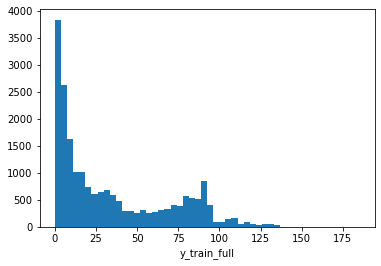

In [6]:
# Histogram of the target variable
plt.hist(y_train_full,bins=50)
plt.xlabel("y_train_full")

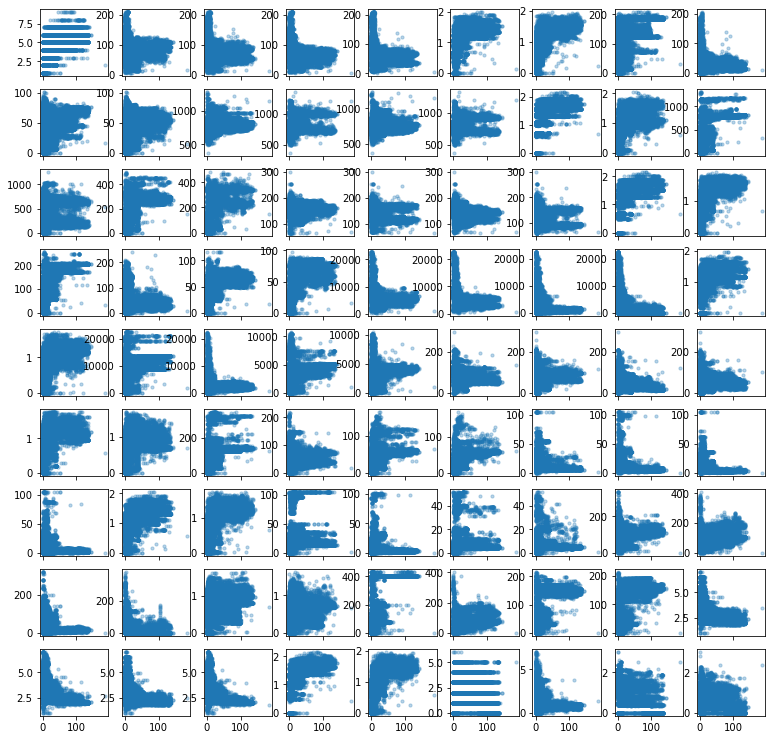

In [7]:
# Scatter plots of the target variable vs. features
fig, axes = plt.subplots(9,9,figsize=(13,13),sharex=True)
for i, ax in enumerate(axes.flat):
    ax.scatter(y_train_full[:,0],X_train_full[:,i],alpha=.3,s=10)

In [8]:
# Normalize
def norm(arr):
    arr_bef=arr.copy()
    for i in range(arr.shape[1]):
        arr[:,i]=(arr[:,i]-arr[:,i].mean())/arr[:,i].std()
    vnames = [name for name in globals() if globals()[name] is arr]
    print("Normalisierung von",f"{vnames}")
    for i in range(5):
        print("feature",i,"\tmean before:",arr_bef[:,i].mean(),"\tafter:",arr[:,i].mean(),"\tstd before:",arr_bef[:,i].std(),"\tafter:",arr[:,i].std())
norm(X_train)
norm(X_test)
norm(X_train_full)

Normalisierung von ['X_train']
feature 0 	mean before: 4.185 	after: 2.9309887850104134e-16 	std before: 1.5102234933942724 	after: 0.9999999999999999
feature 1 	mean before: 87.71633360217524 	after: -2.3092638912203257e-16 	std before: 29.24216733759368 	after: 1.0
feature 2 	mean before: 73.21230300793641 	after: -4.796163466380677e-16 	std before: 31.443899465243085 	after: 1.0
feature 3 	mean before: 71.15119648685723 	after: -3.8635761256955447e-16 	std before: 30.725859874747538 	after: 1.0
feature 4 	mean before: 58.43925604980193 	after: 8.43769498715119e-17 	std before: 34.87710465494954 	after: 1.0
Normalisierung von ['X_test']
feature 0 	mean before: 4.24 	after: -1.6697754290362354e-16 	std before: 1.419295599936814 	after: 0.9999999999999999
feature 1 	mean before: 85.46262335692079 	after: -7.069900220812997e-16 	std before: 28.444589236496295 	after: 1.0
feature 2 	mean before: 70.43142338625537 	after: 2.5579538487363605e-16 	std before: 30.20466364433349 	after: 0.999

Which material properties may be useful for predicting superconductivity? What other observations can you make?

As we can see in the scatter plot, there is no perfect indicator and most of the data look like theres no correlation at all, but some trend can be found in the mirrored L shape data.
Many plots look alike.

## Task 2:  Implement your own OLS estimator

We want to use linear regression to predict the critical temperature. Implement the ordinary least squares estimator without regularization 'by hand':

$w = (X^TX)^{-1}X^Ty$

To make life a bit easier, we provide a function that can be used to plot regression results. In addition it computes the mean squared error and the squared correlation between the true and predicted values. 

In [9]:
def plot_regression_results(y_test, y_pred, weights):
    '''Produces three plots to analyze the results of linear regression:
        -True vs predicted
        -Raw residual histogram
        -Weight histogram

    Inputs:
        y_test: (n_observations,) numpy array with true values
        y_pred: (n_observations,) numpy array with predicted values
        weights: (n_weights) numpy array with regression weights'''

    print('MSE: ', mean_squared_error(y_test, y_pred))
    print('r^2: ', r2_score(y_test, y_pred))

    fig, ax = plt.subplots(1, 3, figsize=(9, 3))
    # predicted vs true
    ax[0].scatter(y_test, y_pred)
    ax[0].set_title('True vs. Predicted')
    ax[0].set_xlabel('True %s' % (target_clm))
    ax[0].set_ylabel('Predicted %s' % (target_clm))

    # residuals
    error = np.squeeze(np.array(y_test)) - np.squeeze(np.array(y_pred))
    ax[1].hist(np.array(error), bins=30)
    ax[1].set_title('Raw residuals')
    ax[1].set_xlabel('(true-predicted)')

    # weight histogram
    ax[2].hist(weights, bins=30)
    ax[2].set_title('weight histogram')

    plt.tight_layout()

As an example, we here show you how to use this function with random data. 

MSE:  2640.432578444892
r^2:  -1.108062856115481


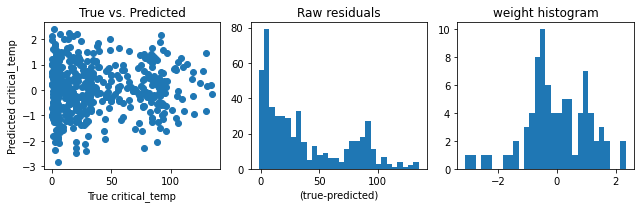

In [10]:
# weights is a vector of length 82: the first value is the intercept (beta0), then 81 coefficients
weights = np.random.randn(82)

# Model predictions on the test set
y_pred_test = np.random.randn(y_test.size)

plot_regression_results(y_test, y_pred_test, weights)

Implement OLS linear regression yourself. Use `X_train` and `y_train` for estimating the weights and compute the MSE and $r^2$ from `X_test`. When you call our plotting function with the regession result, you should get mean squared error of 707.8.

In [11]:
def OLS_regression(X_test, X_train, y_train):
    '''Computes OLS weights for linear regression without regularization on the training set and
       returns weights and testset predictions.

       Inputs:
         X_test: (n_observations, 81), numpy array with predictor values of the test set
         X_train: (n_observations, 81), numpy array with predictor values of the training set
         y_train: (n_observations,) numpy array with true target values for the training set

       Outputs:
         weights: The weight vector for the regerssion model including the offset
         y_pred: The predictions on the TEST set

       Note:
         Both the training and the test set need to be appended manually by a columns of 1s to add
         an offset term to the linear regression model.
    '''

    # ---------------- INSERT CODE ----------------------
    X_train_aug=np.hstack((np.ones((X_train.shape[0],1)),X_train))
    X_test_aug=np.hstack((np.ones((X_test.shape[0],1)),X_test))
    weights=inv((X_train_aug.T@X_train_aug))@(X_train_aug.T)@y_train
    #weights_=weights.reshape(-1,1)
    y_pred=X_test_aug@weights
    # ---------------- END CODE -------------------------

    return weights, y_pred

MSE:  707.8008844913566
r^2:  0.43490745936762654


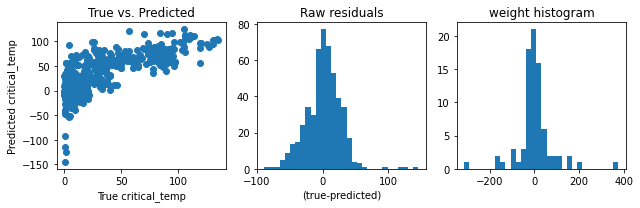

In [12]:
# Plots of the results
weights, y_pred = OLS_regression(X_test, X_train, y_train)
plot_regression_results(y_test, y_pred, weights)

What do you observe? Is the linear regression model good?

Its doing alright, the true vs. predicted is showing a slight trend towards the identety function(which would be best case) and r^2 is way higher which is good.

## Task 3: Compare your implementation to sklearn

Now, familarize yourself with the sklearn library. In the section on linear models:

https://scikit-learn.org/stable/modules/classes.html#module-sklearn.linear_model

you will find `sklearn.linear_model.LinearRegression`, the `sklearn` implementation of the OLS estimator. Use this sklearn class to implement OLS linear regression. Again obtain estimates of the weights on `X_train` and `y_train` and compute the MSE and $r^2$ on `X_test`.


In [13]:
def sklearn_regression(X_test, X_train, y_train):
    '''Computes OLS weights for linear regression without regularization using the sklearn library on the training set and
       returns weights and testset predictions.

       Inputs:
         X_test: (n_observations, 81), numpy array with predictor values of the test set
         X_train: (n_observations, 81), numpy array with predictor values of the training set
         y_train: (n_observations,) numpy array with true target values for the training set

       Outputs:
         weights: The weight vector for the regerssion model including the offset
         y_pred: The predictions on the TEST set

       Note:
         The sklearn library automatically takes care of adding a column for the offset.
    '''

    # ---------------- INSERT CODE ----------------------
    #from sklearn.linear_model import LinearRegression
    reg = linear_model.LinearRegression().fit(X_train, y_train)
    y_pred=reg.predict(X_test)
    weights=reg.get_params()
    # ---------------- END CODE -------------------------

    return weights, y_pred

MSE:  707.8008845059932
r^2:  0.4349074593559409


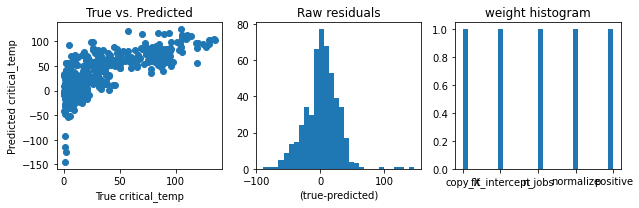

In [14]:
weights, y_pred = sklearn_regression(X_test, X_train, y_train)
plot_regression_results(y_test, y_pred, weights)

If you implemented everything correctly, the MSE is again 707.8.

Fit the model using the larger training set, `X_train_full` and `y_train_full`, and again evaluate on `X_test`.

MSE:  340.87282138811946
r^2:  0.7278546934719323


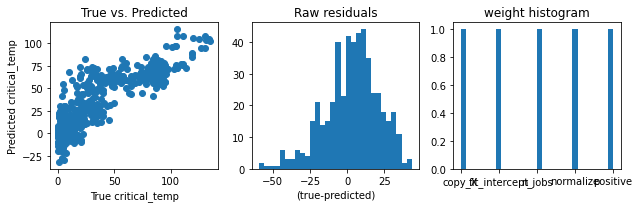

In [15]:
weights, y_pred = sklearn_regression(X_test, X_train_full, y_train_full)
plot_regression_results(y_test, y_pred, weights)

 How does test set performance change? What else changes?

The performance got way better(r^2 is closer to 1) and the true vs predicted values are closer to the identidy. Errors are less wide as we can see in 2. Plot

## Task 4: Regularization with ridge regression

We will now explore how a penalty term on the weights can improve the prediction quality for finite data sets. Implement the analytical solution of ridge regression 

$w = (X^TX + \alpha I_D)^{-1}X^Ty$


as a function that can take different values of $\alpha$, the regularization strength, as an input. In the lecture, this parameter was called $\lambda$, but this is a reserved keyword in Python.

In [16]:
def ridge_regression(X_test, X_train, y_train, alpha):
    '''Computes OLS weights for regularized linear regression with regularization strength alpha
       on the training set and returns weights and testset predictions.

       Inputs:
         X_test: (n_observations, 81), numpy array with predictor values of the test set
         X_train: (n_observations, 81), numpy array with predictor values of the training set
         y_train: (n_observations,) numpy array with true target values for the training set
         alpha: scalar, regularization strength

       Outputs:
         weights: The weight vector for the regression model including the offset
         y_pred: The predictions on the TEST set

       Note:
         Both the training and the test set need to be appended manually by a columns of 1s to add
         an offset term to the linear regression model.
    '''

    # ---------------- INSERT CODE ----------------------
    X_train_aug=np.hstack((np.ones((X_train.shape[0],1)),X_train))
    X_test_aug=np.hstack((np.ones((X_test.shape[0],1)),X_test))
    weights=inv(X_train_aug.T@X_train_aug+alpha*np.identity(X_train_aug.shape[1]))@X_train_aug.T@y_train
    y_pred=X_test_aug@weights
    # ---------------- END CODE -------------------------

    return weights, y_pred

Run the ridge regression on `X_train` with an alpha value of 10 and plot the obtained weights.

MSE:  428.09796358695996
r^2:  0.6582160729330726


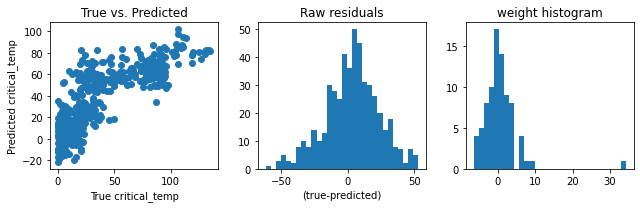

In [17]:
# Run ridge regression with alpha=10
weights, y_pred = ridge_regression(X_test, X_train, y_train, 10)
# Plot regression results
plot_regression_results(y_test, y_pred, weights)

Now test a range of log-spaced $\alpha$s (~10-20), which cover several orders of magnitude, e.g. from 10^-7 to 10^7. 

* For each $\alpha$, you will get one model with one set of weights. 
* For each model, compute the error on the test set. 

Store both the errors and weights of all models for later use. You can use the function `mean_squared_error` from sklearn (imported above) to compute the MSE.



In [18]:

# ---------------- INSERT CODE ----------------------
alphas = np.logspace(-7, 7, 100)
weights_arr=[]
errors=[]
for alpha in alphas:
    weights, y_pred = ridge_regression(X_test, X_train, y_train, alpha)
    error=mean_squared_error(y_test,y_pred)
    weights_arr.append(weights)
    errors.append(error)
# ---------------- END CODE -------------------------

Make a single plot that shows for each coefficient how it changes with $\alpha$, i.e. one line per coefficient. Also think about which scale is appropriate for your $\alpha$-axis. You can set this using `plt.xscale(...)`.

Text(0, 0.5, 'Coeff')

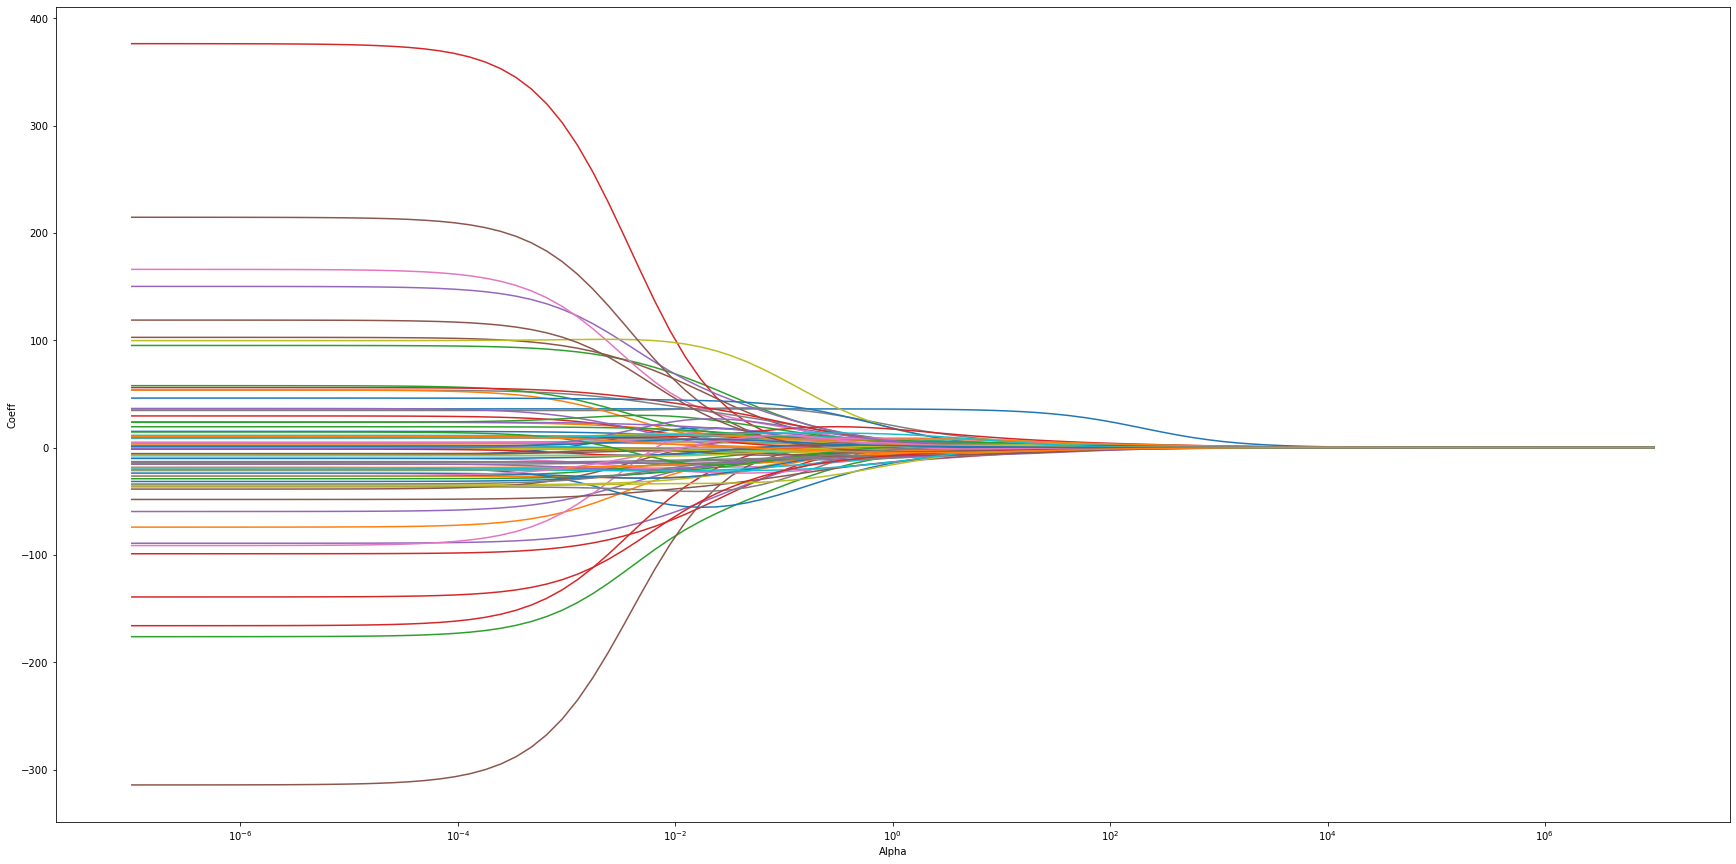

In [19]:
# Plot of coefficients vs. alphas
weights_arr=np.array(weights_arr)
weights_arr=weights_arr.reshape((100, 82))
fig,ax =plt.subplots(figsize=(30,15))
for w in range(weights_arr.shape[1]):
    ax.plot(alphas,weights_arr[:,w])
plt.xscale(value="log")
ax.set_xlabel("Alpha")
ax.set_ylabel("Coeff")

Why are the values of the weights largest on the left? Do they all change monotonically? 

Since we dont punish huge weights on the left, they can be as big as it needs to be to minimize the error. The higher the alpha the more big weights cost, which leads to smaller weight.
No generally they are not monotonically.


Plot how the performance (i.e. the error) changes as a function of $\alpha$. As a sanity check, the MSE value for very small $\alpha$ should be close to the test-set MSE of the unregularized solution, i.e. 708.

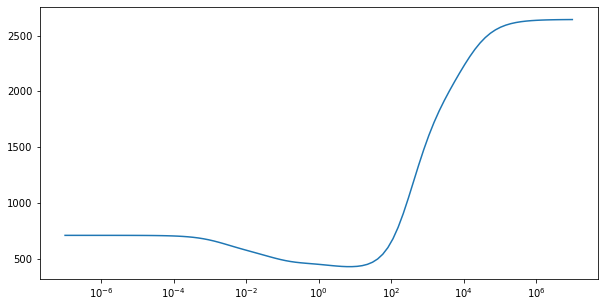

In [20]:
# Plot of MSE  vs. alphas
fig,ax =plt.subplots(figsize=(10,5))
ax.plot(alphas,errors)
plt.xscale(value="log")

Which value of $\alpha$ gives the minimum MSE? Is it better than the unregularized model? Why should the curve reach ~700 on the left?

In [21]:
alphas[errors==min(errors)]

array([8.30217568])

The minimizer of the MSE is 8.3=$\alpha_{min}$. The more left you are on the curve, the closer alpha is to 0, which means the closer we are for the normal regression, without a regularization. (for normal regression we had mse 700)

Now implement the same model using sklearn. Use the `linear_model.Ridge` object to do so.


In [22]:
def ridge_regression_sklearn(X_test, X_train, y_train, alpha):
    '''Computes OLS weights for regularized linear regression with regularization strength alpha using the sklearn
       library on the training set and returns weights and testset predictions.

       Inputs:
         X_test: (n_observations, 81), numpy array with predictor values of the test set
         X_train: (n_observations, 81), numpy array with predictor values of the training set
         y_train: (n_observations,) numpy array with true target values for the training set
         alpha: scalar, regularization strength

       Outputs:
         weights: The weight vector for the regerssion model including the offset
         y_pred: The predictions on the TEST set

       Note:
         The sklearn library automatically takes care of adding a column for the offset.
    '''

    # ---------------- INSERT CODE ----------------------
    clf=linear_model.Ridge(alpha=alpha)
    clf.fit(X_train, y_train)
    y_pred=clf.predict(X_test)
    weights=clf.get_params()

    # ---------------- END CODE -------------------------

    return weights, y_pred

This time, only plot how the performance changes as a function of $\alpha$. 

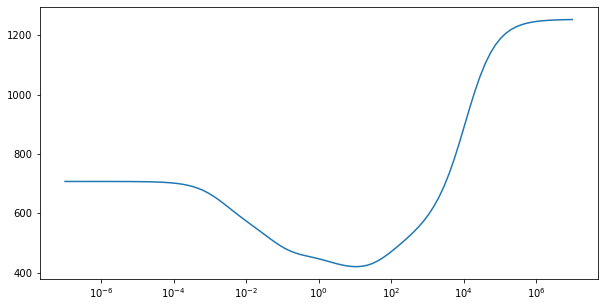

In [23]:
# Plot of MSE  vs. alphas
# ---------------- INSERT CODE ----------------------
errors=[]
for alpha in alphas:
    weights, y_pred = ridge_regression_sklearn(X_test, X_train, y_train, alpha)
    error=mean_squared_error(y_test,y_pred)
    errors.append(error)
fig,ax =plt.subplots(figsize=(10,5))
ax.plot(alphas,errors)
plt.xscale(value="log")

Note: Don't worry if the curve is not exactly identical to the one you got above. The loss function we wrote down in the lecture  has $\alpha$ defined a bit differently compared to sklearn. However, qualitatively it should look the same.

## Task 5: Cross-validation

Until now, we always estimated the error on the test set directly. However, we typically do not want to tune hyperparameters of our inference algorithms like $\alpha$ on the test set, as this may lead to overfitting. Therefore, we tune them on the training set using cross-validation. As discussed in the lecture, the training data is here split in `n_folds`-ways, where each of the folds serves as a held-out dataset in turn and the model is always trained on the remaining data. Implement a function that performs cross-validation for the ridge regression parameter $\alpha$. You can reuse functions written above.

In [24]:
def ridgeCV(X, y, n_folds, alphas):
    '''Runs a n_fold-crossvalidation over the ridge regression parameter alpha.
       The function should train the linear regression model for each fold on all values of alpha.

      Inputs:
        X: (n_obs, n_features) numpy array - predictor
        y: (n_obs,) numpy array - target
        n_folds: integer - number of CV folds
        alphas: (n_parameters,) - regularization strength parameters to CV over

      Outputs:
        cv_results_mse: (n_folds, len(alphas)) numpy array, MSE for each cross-validation fold

      Note:
        Fix the seed for reproducibility.
    '''

    cv_results_mse = np.zeros((n_folds, len(alphas)))
    np.random.seed(seed=2)

    # ---------------- INSERT CODE ----------------------
    d=X.shape[0]
    n=d%n_folds
    k=0
    for ind in range(n_folds):
        if(n==0):
            k1=(k+int(d/n_folds))
        else:
            n-=1
            k1=(k+int(d/n_folds))+1
        xtest=X[k:k1]
        arr1=X[0:k]
        arr2=X[k1:]
        xtrain=np.concatenate((arr1,arr2))
        arr1=y[0:k]
        arr2=y[k1:]
        y_train=np.concatenate((arr1,arr2))
        y_test=y[k:k1]
        errors=[]
        for alpha in alphas:
            weights, y_pred = ridge_regression_sklearn(xtest, xtrain, y_train, alpha)
            error=mean_squared_error(y_test,y_pred)
            errors.append(error)
        cv_results_mse[ind]=errors
        k=k1
        
        
                              
                        

    # ---------------- END CODE -------------------------

    return cv_results_mse

Now we run 10-fold cross-validation using the training data of a range of $\alpha$s.

In [25]:
alphas = np.logspace(-7, 7, 100)
mse_cv = ridgeCV(X_train, y_train, n_folds=10, alphas=alphas)

In [26]:
mse_cv.shape

(10, 100)

We plot the MSE trace for each fold separately:

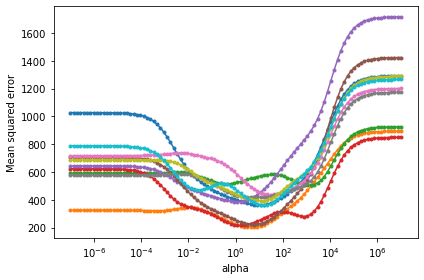

In [27]:
plt.plot(alphas, mse_cv.T, '.-')
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('Mean squared error')
plt.tight_layout()

We also plot the average across folds:

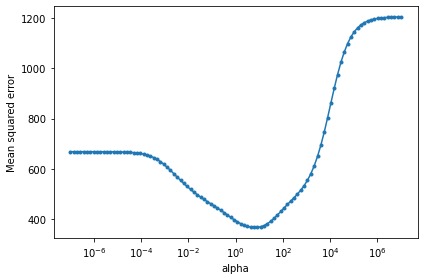

In [28]:
plt.figure(figsize=(6, 4))
plt.plot(alphas, np.mean(mse_cv, axis=0), '.-')
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('Mean squared error')
plt.tight_layout()

What is the optimal $\alpha$? Is it similar to the one found on the test set? Do the cross-validation MSE and the test-set MSE match well or differ strongly?

In [29]:
alphas[np.mean(mse_cv, axis=0)==min(np.mean(mse_cv, axis=0))]

array([5.9948425])

Optimal $\alpha$ is 6. Its similar but 2 lower then for the test set , which was around 8. The cv MSE is goes way lower then the test-set MSE, they start almost the same but for larger alpha the test-set MSE increases way faster then the CV one.

We will now run cross-validation on the full training data. This will take a moment, depending on the speed of your computer. Afterwards, we will again plot the mean CV curves for the full data set (blue) and the small data set (orange).

In [30]:
alphas = np.logspace(-7, 7, 100)
mse_cv_full = ridgeCV(X_train_full, y_train_full, n_folds=10, alphas=alphas)

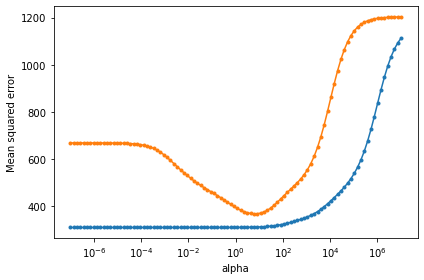

In [31]:
plt.figure(figsize=(6, 4))
plt.plot(alphas, np.mean(mse_cv_full, axis=0), '.-')
plt.plot(alphas, np.mean(mse_cv, axis=0), '.-')
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('Mean squared error')
plt.tight_layout()

We zoom in on the blue curve to the very left:

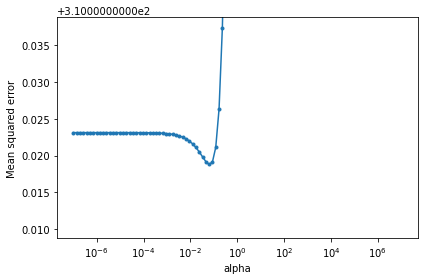

In [32]:
plt.figure(figsize=(6, 4))
plt.plot(alphas, np.mean(mse_cv_full, axis=0), '.-')
plt.xscale('log')
minValue = np.min(np.mean(mse_cv_full, axis=0))
plt.ylim([minValue-.01, minValue+.02])
plt.xlabel('alpha')
plt.ylabel('Mean squared error')
plt.tight_layout()

Why does the CV curve on the full data set look so different? What is the optimal value of $\alpha$ and why is it so much smaller than on the small training set?

In [33]:
alphas[np.mean(mse_cv_full, axis=0)==np.min(np.mean(mse_cv_full, axis=0))]

array([0.06280291])

Optimal $\alpha$ is .062. It seems that with this big of a dataset like on the full one, the model is overfitted with many high weights which seems to predict the data well, but it contains a lot of noise.
Bc of the high weights it chooses a small alpha to keep the MSE low. On a new Test set, (maybe smaller) it will perform bad (Thats our guess atleast)

In [55]:
from sklearn import linear_model
clf = linear_model.Ridge(alpha=.8)
clf.fit(X_train,y_train)
clf.score(X_test,y_test)

0.6406912461954672

MSE:  450.04850615040266
r^2:  0.6406912461954672


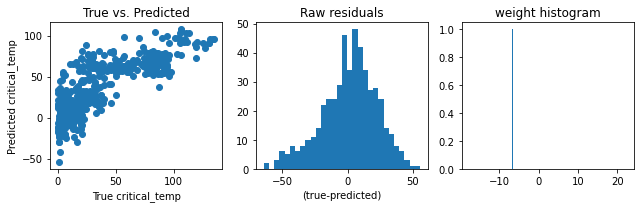

In [56]:
# Run ridge regression with alpha=10
# Plot regression results
plot_regression_results(y_test, clf.predict(X_test), clf.coef_)